# Step 0.1. Import necessary libraries 

In [1]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import typing

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.dataset.roles import DatetimeRole

In [19]:
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

# Step 0.3. Data load 

In [3]:
%%time

train_data = pd.read_csv('./data/train.csv')
train_data.head()

[2021-09-25 09:38:32,907] (WARNING): <decorator-gen-54>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



CPU times: user 1.12 s, sys: 95.6 ms, total: 1.22 s
Wall time: 1.22 s


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [4]:
test_data = pd.read_csv('./data/test.csv')
test_data.head()

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
0,Курск,1.0,COL_289284,7,55,85,117,0,0,0,...,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
1,Сургут,1.0,COL_289305,8,70,112,140,0,0,0,...,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
2,Тюмень,-1.0,COL_289318,3,28,67,122,0,0,0,...,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1
3,Иркутск,1.0,COL_289354,5,76,139,231,0,0,0,...,1947.073276,1941.657895,Иркутская область,52.281380,104.282975,66.503622,S14207,2020-09-06,100,1
4,Курск,NaN,COL_289399,8,105,189,279,0,0,2,...,1948.764151,1946.689655,Курская область,51.729706,36.194019,23.864915,S20658,2020-09-06,10,1


In [5]:
submission = pd.read_csv('./data/test_submission.csv')
submission.head()

,id,per_square_meter_price
0,COL_289284,0
1,COL_289305,0
2,COL_289318,0
3,COL_289354,0
4,COL_289399,0


In [6]:
print(train_data.shape)
print(test_data.shape)

(279792, 77)
(2974, 76)


# Step 0.2. Parameters 

In [20]:
N_THREADS = 16 # threads cnt for lgbm and linear models
N_FOLDS = 7 # folds cnt for AutoML, best 7
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.1 # Test size for metric check
TIMEOUT = 3*3600 # Time in seconds for automl run
TARGET_NAME = 'per_square_meter_price' # Target column name

# Step 0.4. Some user feature preparation 

In [8]:
def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

# ========= AutoML preset usage =========


## Step 1. Create Task

In [9]:
%%time

task = Task('reg', loss='mse', metric=deviation_metric, greater_is_better=False)

CPU times: user 311 µs, sys: 33 µs, total: 344 µs
Wall time: 351 µs


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [31]:
NUM_FEATURES = ['lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
      'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
       'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
       'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
       'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
       'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
       'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
       'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
       'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
       'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
       'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01',
       'osm_transport_stop_closest_dist', 'osm_transport_stop_points_in_0.005',
       'osm_transport_stop_points_in_0.0075',
       'osm_transport_stop_points_in_0.01',
       'reform_count_of_houses_1000', 'reform_count_of_houses_500',
       'reform_house_population_1000', 'reform_house_population_500',
       'reform_mean_floor_count_1000', 'reform_mean_floor_count_500',
       'reform_mean_year_building_1000', 'reform_mean_year_building_500','total_square']

In [11]:
CATEGORICAL_STE_FEATURES = ['region', 'city', 'realty_type']

In [32]:
NUM_FEATURES.append(TARGET_NAME)

In [35]:
train_new = train_data[NUM_FEATURES]

In [41]:
%%time

roles = {'target': TARGET_NAME,
         #'drop': ['id', 'floor'],
         #'numeric': NUM_FEATURES,
         #'category': CATEGORICAL_STE_FEATURES,
         #DatetimeRole(base_date=False, base_feats=True, seasonality=('y', 'm', 'd')): 'date'
         }

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 11.7 µs


## Step 3. Create AutoML from preset

To create AutoML model here we use `TabularAutoML` preset, which looks like:

![TabularAutoML preset pipeline](https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_2_pipeline.png)

All params we set above can be send inside preset to change its configuration:

In [ ]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb_tuned', 'lgb','cd']]},
                       #tuning_params = {'fit_on_holdout':True, 'max_tuning_iter': 201, 'max_tuning_time': 500},
                       lgb_params = {'default_params': {'num_threads': N_THREADS}},
                       cb_params = {'default_params':{'task_type': "GPU"}}
                      )
oof_pred = automl.fit_predict(train_new, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 16 cores
- memory: 16 gb

Train data shape: (279792, 68)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10793.25822854042 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 8.22228e+09	valid's Opt metric: 3.98809
[200]	valid's l2: 7.36778e+09	valid's Opt metric: 3.77167
[300]	valid's l2: 6.97931e+09	valid's Opt metric: 3.68349
[400]	valid's l2: 6.70158e+09	valid's Opt metric: 3.62095
[500]	valid's l2: 6.48876e+09	valid's Opt metric: 3.56996
[600]	valid's l2: 6.32923e+09	valid's Opt metric: 3.52694
[700]	valid's l2: 6.188e+09	valid's Opt metric: 3.49527
[800]	valid's l2: 6.07246e+09	valid's Opt metric: 3.4638
[900]	valid's l2: 5.9788e+09	valid's Opt metric: 3.43346
[1000]	valid's l2: 5.90556e+09	valid's Opt metric: 3.40965
[1100]	vali

CPU times: user 110 ms, sys: 3.96 ms, total: 114 ms
Wall time: 117 ms


<AxesSubplot:xlabel='Feature'>

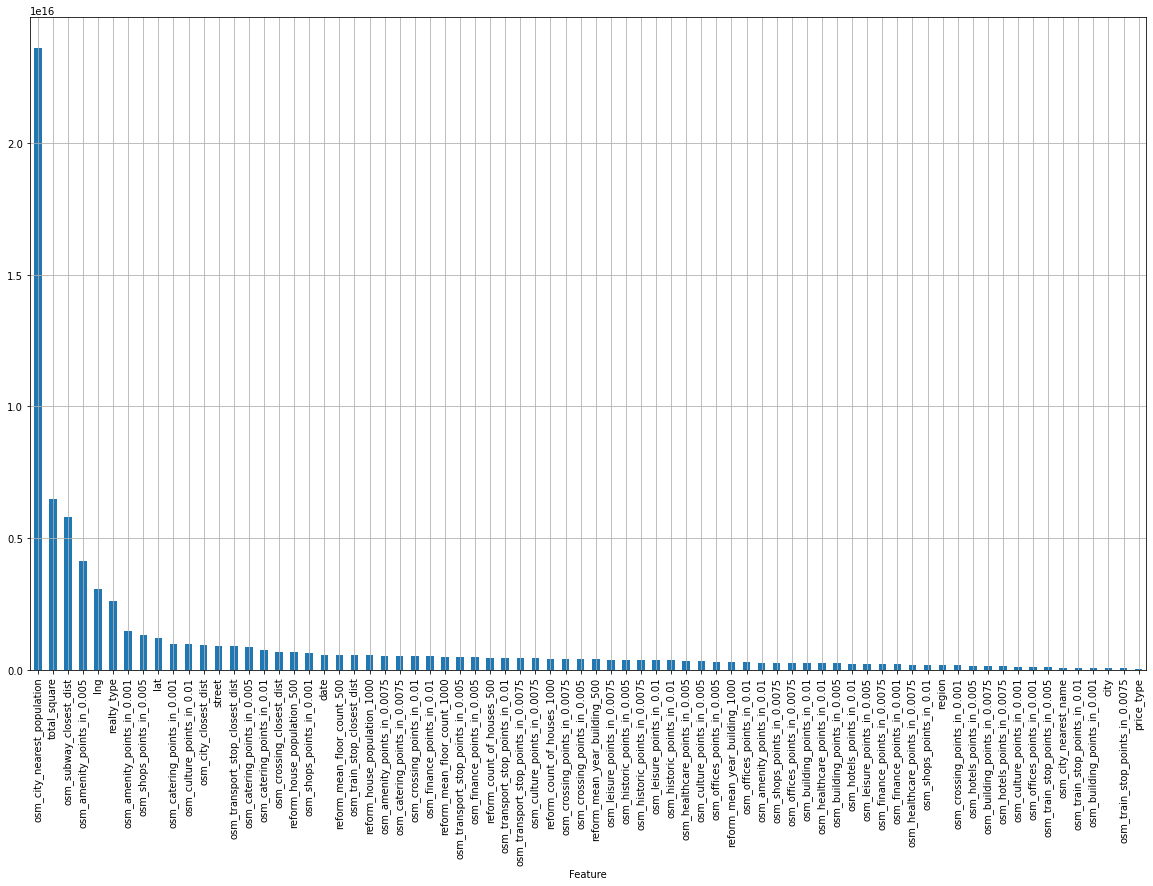

In [23]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 12), grid = True)

## Step 4. Predict to test data and check scores

In [24]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

[2021-09-25 11:43:59,500] (INFO): Prediction for test data:
array([[38519.965],
       [54549.316],
       [51106.117],
       ...,
       [51706.305],
       [58667.97 ],
       [47155.79 ]], dtype=float32)
Shape = (2974, 1)
[2021-09-25 11:43:59,501] (INFO): Check scores...
[2021-09-25 11:43:59,502] (INFO): OOF score: 29267.990025748266


CPU times: user 7 s, sys: 27.9 ms, total: 7.02 s
Wall time: 528 ms


## Step 5. Generate submission

In [25]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.head()

,id,per_square_meter_price
0,COL_289284,38519.964844
1,COL_289305,54549.316406
2,COL_289318,51106.117188
3,COL_289354,105129.343750
4,COL_289399,62251.871094


In [26]:
submission.to_csv('submission_test.csv', index = False)